C:\Users\briac\AppData\Local\Temp\ipykernel_15800\3425875240.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('tickers_transformed.csv', index_col='Date', parse_dates=True)


Aperçu du fichier CSV :
           Amazon  Apple  Microsoft
Date                               
Amazon        NaN    NaN        NaN
1/4/2013   12.958   18.0      26.74
1/11/2013  13.397   18.0      26.83
1/18/2013  13.606   17.0      27.25
1/25/2013  14.200   15.0      27.88
<class 'pandas.core.frame.DataFrame'>
Index: 575 entries, Amazon to 12/29/2023
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Amazon     574 non-null    float64
 1   Apple      574 non-null    float64
 2   Microsoft  574 non-null    float64
dtypes: float64(3)
memory usage: 18.0+ KB
None


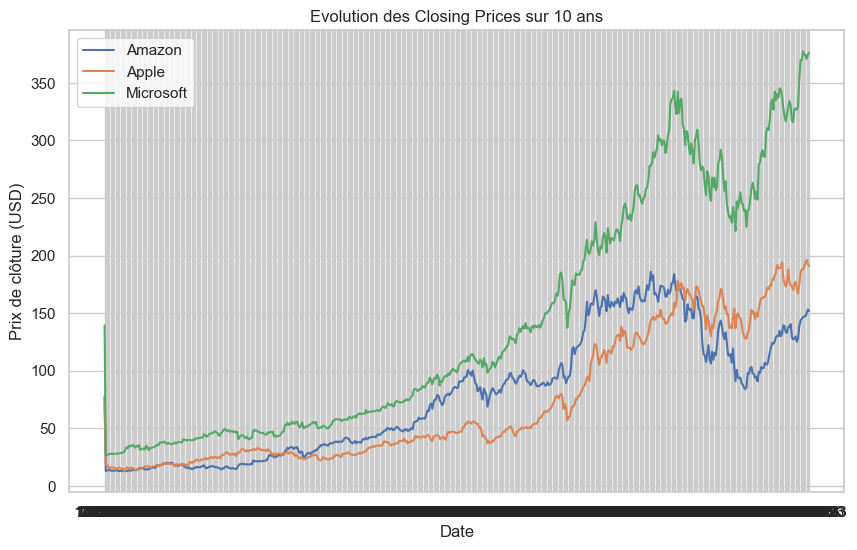

Statistiques des rendements hebdomadaires :
           count      mean       std       min       25%       50%       75%  \
Amazon     574.0  0.001162  0.085920 -1.795055 -0.019553  0.004484  0.028909   
Apple      574.0  0.001712  0.070349 -1.379277 -0.018019  0.000000  0.029637   
Microsoft  574.0  0.001729  0.076427 -1.651235 -0.012827  0.005289  0.021645   

                max  
Amazon     0.169881  
Apple      0.143101  
Microsoft  0.140028  


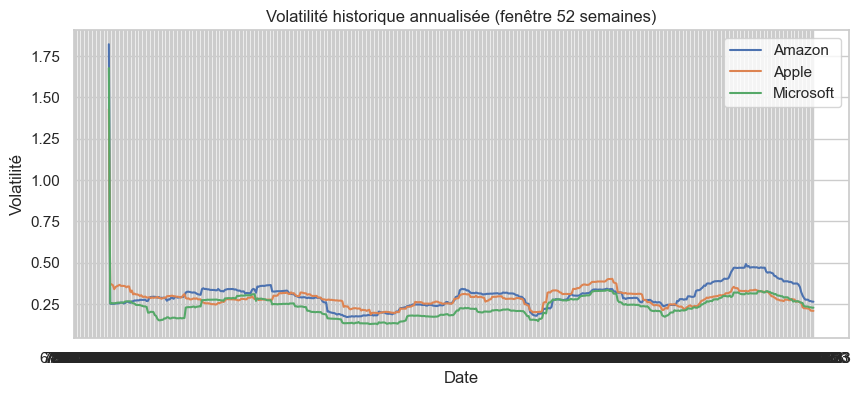

Exemple de prix call Black-Scholes pour Apple (ATM, 3 mois): 7.85 USD
Premiers résultats - Covered Call:
  entry_date  exit_date         S0   S_T     strike  call_premium  \
0     Amazon  1/25/2013  71.496516  15.0  75.071341           NaN   
1  1/25/2013  2/22/2013  15.000000  16.0  15.750000           NaN   
2  2/22/2013  3/22/2013  16.000000  16.0  16.800000           NaN   
3  3/22/2013  4/19/2013  16.000000  13.0  16.800000           NaN   
4  4/19/2013  5/17/2013  13.000000  15.0  13.650000           NaN   

   total_profit  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN   

Premiers résultats - Long Straddle:
  entry_date  exit_date         S0   S_T     strike  premium_call  \
0     Amazon  1/25/2013  71.496516  15.0  71.496516           NaN   
1  1/25/2013  2/22/2013  15.000000  16.0  15.000000           NaN   
2  2/22/2013  3/22/2013  16.000000  16.0  16.000000           NaN   
3  3/22/2013  4/19/2013  16.000000  13.0  16.000000       

KeyError: 'cumulative_profit'

<Figure size 1000x600 with 0 Axes>

In [6]:
# =============================================================================
# 1. Importation des Bibliothèques
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from math import log, sqrt, exp, erf

# Configuration des graphiques
sns.set(style="whitegrid")
plt.rc("figure", figsize=(10,6))

# =============================================================================
# 2. Lecture et Préparation des Données
# =============================================================================
# Supposons que le fichier CSV s'appelle "tickers_selection_10yrs.csv" 
# et que la première colonne correspond aux dates.
# Le fichier doit contenir une colonne "Date" et une colonne pour chaque ticker (ex: AAPL, MSFT, AMZN)
df = pd.read_csv('tickers_transformed.csv', index_col='Date', parse_dates=True)

# Aperçu des données
print("Aperçu du fichier CSV :")
print(df.head())
print(df.info())

# Remplacer les valeurs manquantes par la moyenne de la colonne (imputation simple)
df_imputed = df.fillna(df.mean())

# =============================================================================
# 3. Analyse Exploratoire des Données (EDA)
# =============================================================================
# Visualiser l'évolution des prix ajustés pour chaque ticker
plt.figure(figsize=(10,6))
for ticker in df_imputed.columns:
    plt.plot(df_imputed.index, df_imputed[ticker], label=ticker)
plt.title("Evolution des Closing Prices sur 10 ans")
plt.xlabel("Date")
plt.ylabel("Prix de clôture (USD)")
plt.legend()
plt.show()

# Calculer les rendements hebdomadaires (en supposant que les données du CSV sont hebdomadaires)
returns = np.log(df_imputed / df_imputed.shift(1))
returns = returns.dropna()

# Afficher quelques statistiques descriptives sur les rendements
print("Statistiques des rendements hebdomadaires :")
print(returns.describe().T)

# Calcul de la volatilité historique (annualisée) sur une fenêtre de 52 semaines
volatility = returns.rolling(window=52).std() * np.sqrt(52)
plt.figure(figsize=(10,4))
for ticker in df_imputed.columns:
    plt.plot(volatility.index, volatility[ticker], label=ticker)
plt.title("Volatilité historique annualisée (fenêtre 52 semaines)")
plt.xlabel("Date")
plt.ylabel("Volatilité")
plt.legend()
plt.show()

# =============================================================================
# 4. Modèle de Valorisation des Options : Black-Scholes
# =============================================================================
def norm_cdf(x):
    """Fonction de répartition de la loi normale standard"""
    return 0.5 * (1 + erf(x / sqrt(2)))

def black_scholes_price(S, K, T, r, sigma, option_type="call"):
    """
    Calcule le prix théorique Black-Scholes d'une option européenne.
    S : Prix spot du sous-jacent
    K : Strike
    T : Temps jusqu'à l'échéance (en années)
    r : Taux sans risque
    sigma : Volatilité annualisée du sous-jacent
    option_type : "call" ou "put"
    """
    if T <= 0:
        # Option expiring; valeur intrinsèque
        if option_type == "call":
            return max(0.0, S - K)
        else:
            return max(0.0, K - S)
    d1 = (log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)
    if option_type == "call":
        price = S * norm_cdf(d1) - K * exp(-r*T) * norm_cdf(d2)
    elif option_type == "put":
        price = K * exp(-r*T) * norm_cdf(-d2) - S * norm_cdf(-d1)
    else:
        raise ValueError("option_type doit être 'call' ou 'put'")
    return price

# Exemple de calcul pour AAPL (dernier prix connu du CSV)
ticker_example = 'Apple'  # ou le nom exact de la colonne
S_example = df_imputed[ticker_example].iloc[-1]
prix_call_example = black_scholes_price(S_example, K=S_example, T=0.25, r=0.01, sigma=0.20, option_type="call")
print(f"Exemple de prix call Black-Scholes pour {ticker_example} (ATM, 3 mois): {prix_call_example:.2f} USD")

# =============================================================================
# 5. Définition des Fonctions de Backtesting par Stratégie
# =============================================================================

def backtest_covered_call(price_series, maturity_weeks=4, strike_margin=1.05, r=0.01, sigma=None):
    """
    Backtest d'une stratégie Covered Call sur une série de prix.
    price_series: Série temporelle des prix (p.ex. df_imputed['AAPL'])
    maturity_weeks: Durée en semaines de l'option (ex: 4 pour 1 mois)
    strike_margin: Multiplicateur pour fixer le strike (ex: 1.05 pour 5% au-dessus)
    r: Taux sans risque
    sigma: Volatilité annualisée; si None, calculée à partir des rendements
    """
    results = []
    prices = price_series.copy()
    n = len(prices)
    # Calcul de la volatilité historique si non fourni
    if sigma is None:
        # On estime sigma à partir des rendements hebdomadaires sur une fenêtre de 52 semaines
        vol_series = returns[price_series.name].rolling(52).std() * np.sqrt(52)
    else:
        vol_series = pd.Series(sigma, index=prices.index)
    
    step = maturity_weeks
    for i in range(0, n - step, step):
        S0 = prices.iloc[i]
        K = S0 * strike_margin
        T = maturity_weeks / 52.0
        sigma_t = vol_series.iloc[max(0, i-1)] if sigma is None else sigma
        call_price = black_scholes_price(S0, K, T, r, sigma_t, option_type="call")
        S_T = prices.iloc[i + step]
        call_payoff = -max(0, S_T - K)
        if S_T > K:
            stock_profit = K - S0
        else:
            stock_profit = S_T - S0
        total_profit = stock_profit + call_price + call_payoff
        results.append({
            "entry_date": prices.index[i],
            "exit_date": prices.index[i + step],
            "S0": S0,
            "S_T": S_T,
            "strike": K,
            "call_premium": call_price,
            "total_profit": total_profit
        })
    return pd.DataFrame(results)

def backtest_straddle(price_series, maturity_weeks=4, r=0.01, sigma=None):
    """
    Backtest d'une stratégie Long Straddle (achat simultané d'un call et d'un put ATM)
    sur la série de prix donnée.
    """
    results = []
    prices = price_series.copy()
    n = len(prices)
    if sigma is None:
        vol_series = returns[price_series.name].rolling(52).std() * np.sqrt(52)
    else:
        vol_series = pd.Series(sigma, index=prices.index)
    
    step = maturity_weeks
    for i in range(0, n - step, step):
        S0 = prices.iloc[i]
        K = S0  # Strike ATM
        T = maturity_weeks / 52.0
        sigma_t = vol_series.iloc[max(0, i-1)] if sigma is None else sigma
        call_price = black_scholes_price(S0, K, T, r, sigma_t, option_type="call")
        put_price  = black_scholes_price(S0, K, T, r, sigma_t, option_type="put")
        premium_total = call_price + put_price
        S_T = prices.iloc[i + step]
        call_payoff = max(0, S_T - K)
        put_payoff  = max(0, K - S_T)
        total_profit = (call_payoff + put_payoff) - premium_total
        results.append({
            "entry_date": prices.index[i],
            "exit_date": prices.index[i + step],
            "S0": S0,
            "S_T": S_T,
            "strike": K,
            "premium_call": call_price,
            "premium_put": put_price,
            "total_profit": total_profit
        })
    return pd.DataFrame(results)

def backtest_bull_call_spread(price_series, maturity_weeks=4, lower_strike_margin=0.95, upper_strike_margin=1.05, r=0.01, sigma=None):
    """
    Backtest d'une stratégie Bull Call Spread sur une série de prix.
    lower_strike_margin: pour déterminer le strike du call acheté (ex: 0.95)
    upper_strike_margin: pour déterminer le strike du call vendu (ex: 1.05)
    """
    results = []
    prices = price_series.copy()
    n = len(prices)
    if sigma is None:
        vol_series = returns[price_series.name].rolling(52).std() * np.sqrt(52)
    else:
        vol_series = pd.Series(sigma, index=prices.index)
    
    step = maturity_weeks
    for i in range(0, n - step, step):
        S0 = prices.iloc[i]
        K1 = S0 * lower_strike_margin
        K2 = S0 * upper_strike_margin
        T = maturity_weeks / 52.0
        sigma_t = vol_series.iloc[max(0, i-1)] if sigma is None else sigma
        call_buy_price = black_scholes_price(S0, K1, T, r, sigma_t, option_type="call")
        call_sell_price = black_scholes_price(S0, K2, T, r, sigma_t, option_type="call")
        net_premium = call_buy_price - call_sell_price
        S_T = prices.iloc[i + step]
        call_buy_payoff = max(0, S_T - K1)
        call_sell_payoff = -max(0, S_T - K2)
        total_profit = (call_buy_payoff + call_sell_payoff) - net_premium
        results.append({
            "entry_date": prices.index[i],
            "exit_date": prices.index[i + step],
            "S0": S0,
            "S_T": S_T,
            "strike_buy": K1,
            "strike_sell": K2,
            "net_premium": net_premium,
            "total_profit": total_profit
        })
    return pd.DataFrame(results)

# =============================================================================
# 6. Exécution du Backtest sur un Ticker Sélectionné
# =============================================================================
# Par exemple, on peut utiliser les données de AAPL
price_series = df_imputed['Apple']

# Choix des paramètres (ici, options mensuelles avec maturité de 4 semaines)
maturity = 4  # en semaines

# Exécution des différentes stratégies
cc_results      = backtest_covered_call(price_series, maturity_weeks=maturity, strike_margin=1.05, r=0.01)
straddle_results= backtest_straddle(price_series, maturity_weeks=maturity, r=0.01)
spread_results  = backtest_bull_call_spread(price_series, maturity_weeks=maturity, lower_strike_margin=0.95, upper_strike_margin=1.05, r=0.01)

print("Premiers résultats - Covered Call:")
print(cc_results.head(), "\n")
print("Premiers résultats - Long Straddle:")
print(straddle_results.head(), "\n")
print("Premiers résultats - Bull Call Spread:")
print(spread_results.head())

# =============================================================================
# 7. Visualisation et Analyse des Performances
# =============================================================================
def performance_metrics(trade_df, freq_weeks):
    """
    Calcule le profit cumulé, le drawdown maximal et le ratio de Sharpe à partir 
    du DataFrame des trades.
    """
    df_perf = trade_df.copy()
    df_perf["cumulative_profit"] = df_perf["total_profit"].cumsum()
    running_max = df_perf["cumulative_profit"].cummax()
    drawdown = df_perf["cumulative_profit"] - running_max
    max_drawdown = drawdown.min()
    max_drawdown_pct = (drawdown / running_max).min() * 100
    returns_trade = df_perf["total_profit"]
    sharpe_ratio = (returns_trade.mean() / returns_trade.std()) * np.sqrt(52/freq_weeks) if returns_trade.std() != 0 else np.nan
    return {
        "final_profit": df_perf["cumulative_profit"].iloc[-1],
        "max_drawdown": max_drawdown,
        "max_drawdown_pct": max_drawdown_pct,
        "sharpe_ratio": sharpe_ratio
    }

cc_perf       = performance_metrics(cc_results, maturity)
straddle_perf = performance_metrics(straddle_results, maturity)
spread_perf   = performance_metrics(spread_results, maturity)

print("Performance Covered Call:", cc_perf)
print("Performance Long Straddle:", straddle_perf)
print("Performance Bull Call Spread:", spread_perf)

# Visualisation des profits cumulés
plt.figure(figsize=(10,6))
plt.plot(cc_results["exit_date"], cc_results["cumulative_profit"], label="Covered Call")
plt.plot(straddle_results["exit_date"], straddle_results["cumulative_profit"], label="Long Straddle")
plt.plot(spread_results["exit_date"], spread_results["cumulative_profit"], label="Bull Call Spread")
plt.title("Evolution des profits cumulés pour chaque stratégie (AAPL)")
plt.xlabel("Date")
plt.ylabel("Profit cumulé (USD)")
plt.legend()
plt.show()
